In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from scipy.interpolate import interpn
from scipy.signal import convolve2d
from tqdm import tqdm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


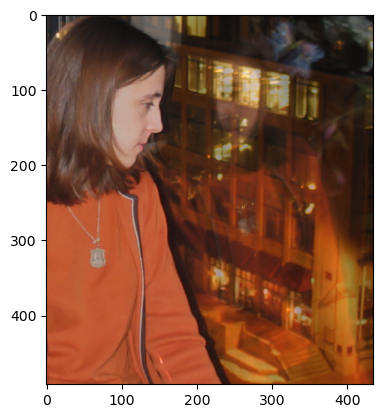

In [11]:
# load images
museum_amb = './data/custom_bonus_1/paper_ambient.png'
museum_flash = './data/custom_bonus_1/paper-reflection.png'
# museum_amb = './data/custom_part1/DSC_1080.JPG'
# museum_flash = './data/custom_part1/DSC_1081.JPG'
skip = 1
museum_amb = cv2.imread(museum_amb,-1)[::skip,::skip,:3][:-50,:,::-1]
museum_flash = cv2.imread(museum_flash,-1)[::skip,::skip,:3][:-50,:,::-1]

# normalize to 0-1
# museum_amb_norm = (museum_amb - np.min(museum_amb)) / (np.max(museum_amb) - np.min(museum_amb))
# museum_flash_norm = (museum_flash - np.min(museum_flash)) / (np.max(museum_flash) - np.min(museum_flash))
museum_amb_norm = museum_amb / 255
museum_flash_norm = museum_flash / 255
# museum_flash_norm_shifted = np.zeros(museum_flash_norm.shape)
# museum_flash_norm_shifted[76//skip:] = museum_flash_norm[:-76//skip]
# museum_flash_norm = museum_flash_norm_shifted
H = museum_amb_norm*2/4  + museum_flash_norm*3/4
plt.imshow(H)

In [12]:
def gradient(img) : 
    
    temp = img[:,:].copy()
    row = np.zeros((1,temp.shape[1]))
    col = np.zeros((temp.shape[0]+2,1))
    temp2 = np.vstack((row,np.vstack((temp, row))))
    temp2 = np.hstack((col,np.hstack((temp2, col))))
    img = temp2.copy() 
    
    # we remove the last row and the last column corresponding to img_x at the end
    # we remove the last col and the last column corresponding to img_y at the end
    
    img_x = np.diff(img,n=1,axis=1) # change along row (i.e. diff bw columns)
    img_y = np.diff(img,n=1,axis=0) # change along column (i.e. diff bw rows) 
#     print(img_x.shape, img_y.shape)
#     img_x, img_y = img_x[:-1,:], img_y[:,:-1]
#     print(img_x.shape, img_y.shape)
    return img_x, img_y # vector field

def divergence(u,v) :
    u_x = np.diff(u,n=1,axis=1) # change along row (i.e. diff bw columns)
    v_y = np.diff(v,n=1,axis=0) # change along column (i.e. diff bw rows)
    u_x, v_y = u_x[1:-1,:], v_y[:,1:-1]
    
    out = u_x + v_y
    return out # scalar field
    
def laplacian(img) :     
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    out = convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)
    return out # scalar field

In [13]:
# Differentiate then re-integrate an image

# Poisson Solver

def conjugate_gradient_descent(I_init, B, I_star_boundary, eps, N, D) :
    
    I_star = B * I_init + (1-B) * I_star_boundary
    r = B * (D - laplacian(I_star))
    d = r.copy() 
    delta_new = np.sum(r*r) # <r,r>
    n = 0
    
    while np.sqrt(np.sum(r*r)) > eps and n < N :
        
        if n % 200 == 0 : print(n,np.sqrt(np.sum(r*r)))
        q = laplacian(d)
        eta = delta_new / np.sum(d*q) # n = delta_new / <d,q>
        
        I_star = I_star + B * (eta * d)
        r = B * (r - eta * q)
        
        delta_old = delta_new.copy()
        delta_new = np.sum(r*r)
        
        beta = delta_new / delta_old 
        d = r + beta * d   
    
        n = n + 1
        
    return I_star

def poisson_solver(lap_img, img, N = 1000, eps = 0.001) :
    
    I_init = np.zeros(img.shape)
    
    boundary_size = 10
    B = np.ones(img.shape)
    B[0:boundary_size,:], B[-boundary_size:-1,:], B[:,0:boundary_size], B[:,-boundary_size:-1] = 0,0,0,0
    
    I_star_boundary = np.zeros(img.shape)
    I_star_boundary[0:boundary_size,:] = img[0:boundary_size,:].copy()
    I_star_boundary[-boundary_size:-1,:] = img[-boundary_size:-1,:].copy()
    I_star_boundary[:,0:boundary_size] = img[:,0:boundary_size].copy()
    I_star_boundary[:,-boundary_size:-1] = img[:,-boundary_size:-1].copy()
    
    I_star = conjugate_gradient_descent(I_init, B, I_star_boundary, eps, N, lap_img) 
    
    return I_star


0 31.84426646509108
200 0.18217253005695647
400 0.0704343601452927
600 0.0076339061194579646
800 0.0010530636841693238
0 20.875489673044942
200 0.10351062478934817
400 0.04289114240389554
600 0.002880652265953053
800 0.00046533325298821275
0 21.534055060107413
200 0.06001455299345685
400 0.024193333498329687
600 0.003232640287154867
800 0.00037635856977812353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


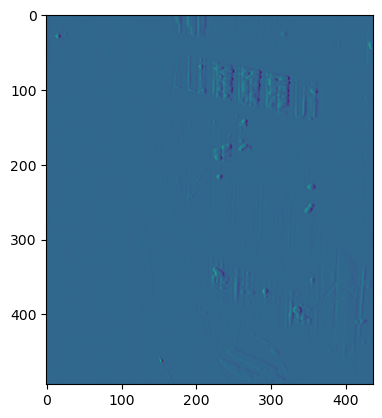

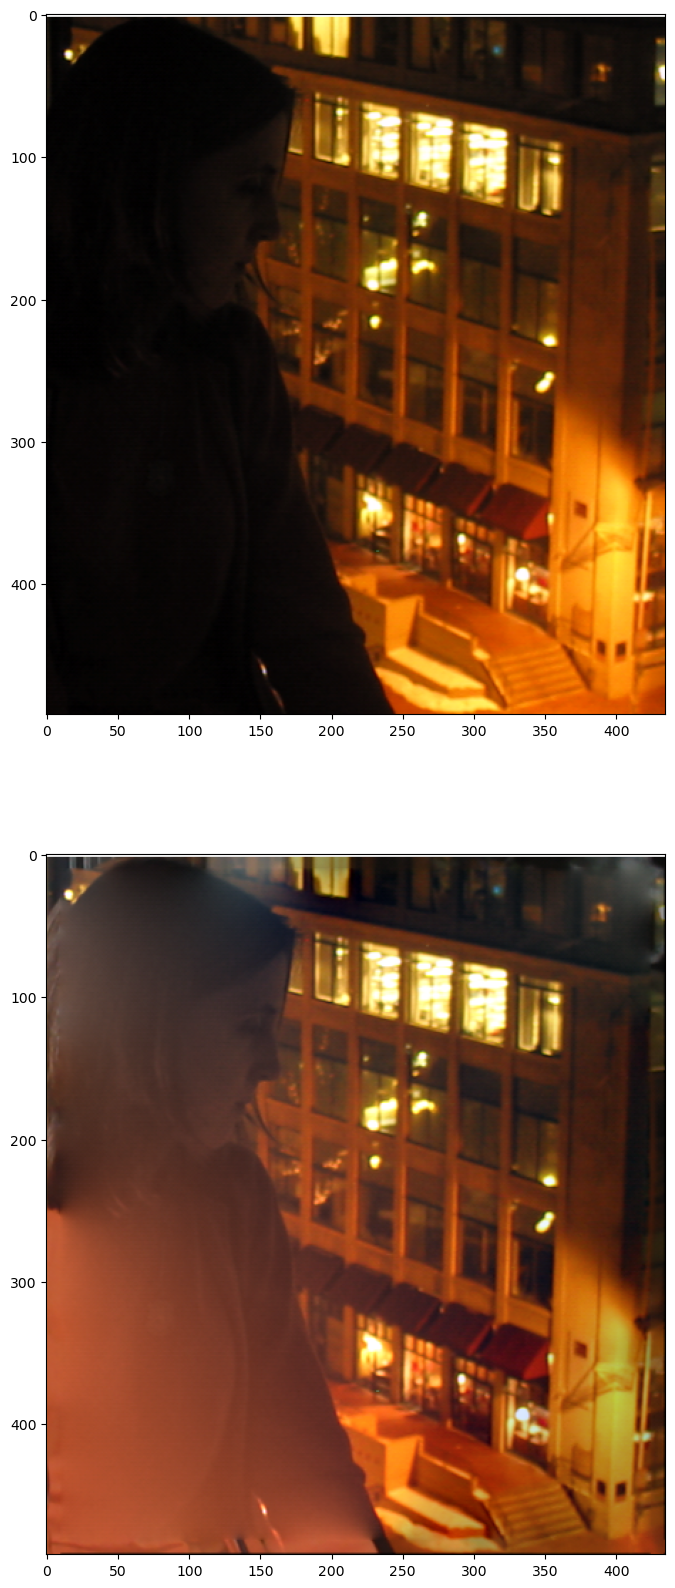

In [14]:
# Creating fused gradient field

def fuse_gradient_field(img_amb_norm, img_flash_norm, H) : 
    
    a_grad_x, a_grad_y = gradient(img_amb_norm)
    phi_dash_grad_x, phi_dash_grad_y = gradient(img_flash_norm)
    h_grad_x, h_grad_y = gradient(H)
    
    a_grad_x_org = a_grad_x.copy()
    a_grad_y_org = a_grad_y.copy()
    phi_dash_grad_x_org = phi_dash_grad_x.copy()
    phi_dash_grad_y_org = phi_dash_grad_y.copy()
    h_grad_x_org = h_grad_x.copy()
    h_grad_y_org = h_grad_y.copy()
    
    a_grad_x, phi_dash_grad_x, h_grad_x = a_grad_x[1:,:], phi_dash_grad_x[1:,:], h_grad_x[1:,:]
    a_grad_y, phi_dash_grad_y, h_grad_y = a_grad_y[:,1:], phi_dash_grad_y[:,1:], h_grad_y[:,1:]
    
    h_proj_alpha = lambda h_grad,a_grad : a_grad * (h_grad * a_grad) / np.sqrt(np.sum(a_grad**2))  
    
    sigma = 0.01
    tau_ue = 0.1
    wue = np.zeros(a_grad_x.shape)
    wue[:-1,:-1] = 1 - np.tanh(sigma * (img_flash_norm-tau_ue))
    wue = (wue - np.min(wue)) / (np.max(wue) - np.min(wue))
#     print(ws.shape, a_grad_x.shape, M.shape, phi_dash_grad_x.shape, a_grad_y.shape, phi_dash_grad_y.shape)
    phi_star_grad_x = np.zeros(a_grad_x_org.shape)
    phi_star_grad_y = np.zeros(a_grad_y_org.shape)
    phi_star_grad_x[1:,:] = wue * a_grad_x + (1-wue) * (h_proj_alpha(h_grad_x, a_grad_x))
    phi_star_grad_y[:,1:] = wue * a_grad_y + (1-wue) * (h_proj_alpha(h_grad_y, a_grad_y))
    plt.imshow(phi_star_grad_x)
    div = divergence(phi_star_grad_x,phi_star_grad_y)
    
    return div
    
fused_image_r_div = fuse_gradient_field(museum_amb_norm[:,:,0], museum_flash_norm[:,:,0], H[:,:,0])
fused_image_g_div = fuse_gradient_field(museum_amb_norm[:,:,1], museum_flash_norm[:,:,1], H[:,:,0])
fused_image_b_div = fuse_gradient_field(museum_amb_norm[:,:,2], museum_flash_norm[:,:,2], H[:,:,0])

I_star_r = poisson_solver(fused_image_r_div, H[:,:,0], N=5000, eps=0.0001)
I_star_g = poisson_solver(fused_image_g_div, H[:,:,1], N=5000, eps=0.0001)
I_star_b = poisson_solver(fused_image_b_div, H[:,:,2], N=5000, eps=0.0001)

I_star = np.concatenate((np.expand_dims(I_star_r,2),np.stack((I_star_g,I_star_b),axis=-1)),axis=2)

fig, ax = plt.subplots(2, figsize = (20,20))

ax[0].imshow(museum_amb_norm)
ax[1].imshow(I_star)

plt.show()

In [8]:
plt.imsave('outputs/reflection_sigma{}_tau{}_5by4.png'.format(0.01,0.1),np.clip(I_star,0,1))

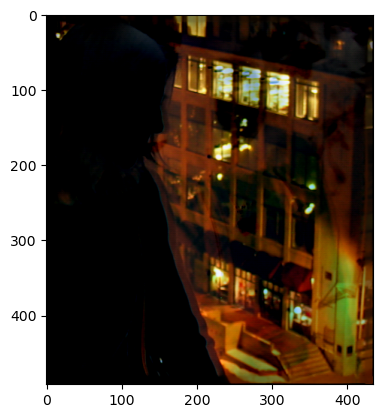

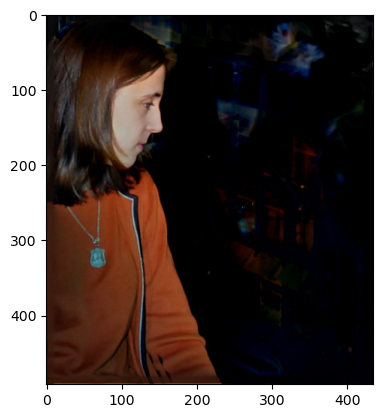

In [15]:
plt.imshow(np.clip(I_star-museum_flash_norm,0,1))
plt.show()
plt.imshow(np.clip(museum_flash_norm-I_star,0,1))
plt.show()

In [ ]:
museum_amb_norm_gradient_x.shape

In [ ]:
museum_amb_norm_gradient_y.shape